In [30]:
!pip install transformers
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Task 1: Acquire and preprocess the IMDB data

In [31]:
import os
import urllib.request
import tarfile
import re
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer

# For Naive Bayes processing
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Download and extract the dataset
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
file_name = "aclImdb_v1.tar.gz"

urllib.request.urlretrieve(url, file_name)

with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()

def nb_clean_text(text):
    # Tokenize and convert to lowercase
    tokens = word_tokenize(text.lower())

    # Remove punctuation and non-alphabetic characters
    words = [word for word in tokens if word.isalpha()]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in lemmatized_words if word not in stop_words]

    return " ".join(filtered_words)    

# Preprocessing function for Naive Bayes
def preprocess_data_naive_bayes(directory):
    data = []
    labels = []

    for sentiment in ["pos", "neg"]:
        path = os.path.join(directory, sentiment)
        for filename in os.listdir(path):
            with open(os.path.join(path, filename), "r") as f:
                text = f.read()
                cleaned_text = nb_clean_text(text)
                data.append(cleaned_text)
                labels.append(1 if sentiment == "pos" else 0)

    vectorizer = TfidfVectorizer(norm='l2')
    X = vectorizer.fit_transform(data)

    return X, labels

# Preprocessing function for BERT
def preprocess_data_bert(directory):
    data = []
    labels = []

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    for sentiment in ["pos", "neg"]:
        path = os.path.join(directory, sentiment)
        for filename in os.listdir(path):
            with open(os.path.join(path, filename), "r") as f:
                text = f.read()
                tokens = tokenizer.encode(text, add_special_tokens=True, max_length=512)
                data.append(tokens)
                labels.append(1 if sentiment == "pos" else 0)

    return data, labels

# Preprocess the data for both models
X_naive_bayes, y_naive_bayes = preprocess_data_naive_bayes("aclImdb/train")
X_bert, y_bert = preprocess_data_bert("aclImdb/train")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


# Task 2: Implement Naive Bayes and BERT models

## Naive Bayes Model Implementation

In [32]:
import numpy as np
from scipy.sparse import csr_matrix

class NaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_log_probs = None
        self.feature_log_probs = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.classes = np.unique(y)
        num_classes = len(self.classes)

        self.class_log_probs = np.zeros(num_classes)
        self.feature_log_probs = np.zeros((num_classes, num_features))

        class_counts = np.zeros(num_classes, dtype=int)

        for c in self.classes:
            class_counts[c] = np.sum(y == c)
            X_class = X[y == c]
            self.feature_log_probs[c] = np.log((X_class.sum(axis=0) + self.alpha) / (class_counts[c] + self.alpha * 2))
            self.class_log_probs[c] = np.log(class_counts[c] / num_samples)

    def predict(self, X):
        num_samples = X.shape[0]
        predictions = np.zeros(num_samples)

        for i, sample in enumerate(X):
            if isinstance(sample, csr_matrix):
                sample = sample.toarray()
            class_log_probs = self.class_log_probs + sample.dot(self.feature_log_probs.T)
            predictions[i] = np.argmax(class_log_probs)

        return predictions


    def evaluate_acc(self, y_true, y_pred):
        accuracy = np.sum(y_pred == y_true) / len(y_true)
        return accuracy


## BERT Model Implementation

In [33]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput

# Define a custom dataset class for BERT
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

    @staticmethod
    def collate_fn(batch):
        X, y = zip(*batch)
        X_padded = torch.nn.utils.rnn.pad_sequence([torch.tensor(x) for x in X], batch_first=True)
        y_tensor = torch.tensor(y)
        return X_padded, y_tensor

class BertForSequenceClassificationWithAttention(BertForSequenceClassification):
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        logits = self.classifier(sequence_output)[:, 0, :]

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT model with attention matrix output
config = BertConfig.from_pretrained("google/bert_uncased_L-4_H-256_A-4", output_attentions=True, num_labels=2)
model = BertForSequenceClassificationWithAttention.from_pretrained("google/bert_uncased_L-4_H-256_A-4", config=config)
model = model.to(device)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-4_H-256_A-4")

# Training parameters
batch_size = 16
epochs = 3
learning_rate = 2e-5

# Create PyTorch dataset and data loader
train_dataset = IMDBDataset(X_bert, y_bert)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size, collate_fn=IMDBDataset.collate_fn)

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop
model.train()
for epoch in range(epochs):
    for step, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Step {step}/{len(train_dataloader)} - Loss: {loss.item()}")

print("Training completed.")

def predict(model, dataloader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch[0].to(device)
            outputs = model(input_ids)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())

    return predictions

def evaluate_acc(y_true, y_pred):
    correct = sum(y1 == y2 for y1, y2 in zip(y_true, y_pred))
    accuracy = correct / len(y_true)
    return accuracy
    

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassificationWithAttention: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassificationWithAttention from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassificationWithAttention from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some wei

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - Step 0/1563 - Loss: 0.6923204064369202
Epoch 1/3 - Step 100/1563 - Loss: 0.7334913611412048
Epoch 1/3 - Step 200/1563 - Loss: 0.7339252233505249
Epoch 1/3 - Step 300/1563 - Loss: 0.500137448310852
Epoch 1/3 - Step 400/1563 - Loss: 0.5138417482376099
Epoch 1/3 - Step 500/1563 - Loss: 0.5057870745658875
Epoch 1/3 - Step 600/1563 - Loss: 0.4130823612213135
Epoch 1/3 - Step 700/1563 - Loss: 0.4585844576358795
Epoch 1/3 - Step 800/1563 - Loss: 0.1305740624666214
Epoch 1/3 - Step 900/1563 - Loss: 0.40377819538116455
Epoch 1/3 - Step 1000/1563 - Loss: 0.35478678345680237
Epoch 1/3 - Step 1100/1563 - Loss: 0.3042253255844116
Epoch 1/3 - Step 1200/1563 - Loss: 0.2962419390678406
Epoch 1/3 - Step 1300/1563 - Loss: 0.7709762454032898
Epoch 1/3 - Step 1400/1563 - Loss: 0.3299735486507416
Epoch 1/3 - Step 1500/1563 - Loss: 0.49053525924682617
Epoch 2/3 - Step 0/1563 - Loss: 0.24578873813152313
Epoch 2/3 - Step 100/1563 - Loss: 0.0654093325138092
Epoch 2/3 - Step 200/1563 - Loss: 0.44751

# Task 3: Run experiments

In [39]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_naive_bayes, y_naive_bayes, test_size=0.1, random_state=1)

# Train Naive Bayes model
naive_bayes = NaiveBayes()
naive_bayes.fit(X_train, y_train)

# Evaluate Naive Bayes model
y_pred = naive_bayes.predict(X_test)
accuracy = naive_bayes.evaluate_acc(y_test, y_pred)
print(f"Naive Bayes accuracy: {accuracy:.8f}")


Naive Bayes accuracy: 0.87160000


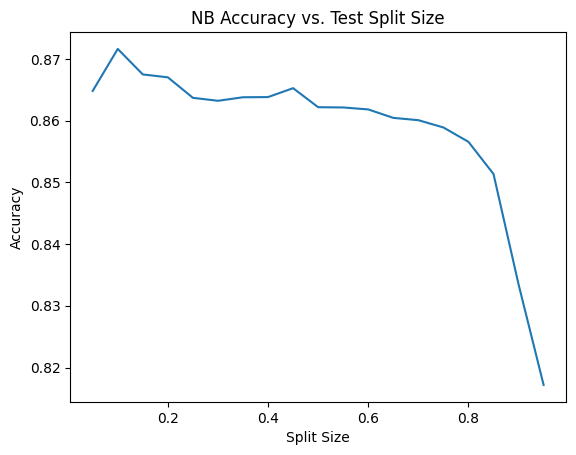

[0.8648, 0.8716, 0.8674666666666667, 0.867, 0.86368, 0.8632, 0.8637714285714285, 0.8638, 0.8652444444444445, 0.86216, 0.8621191186095557, 0.8618, 0.8604307692307692, 0.8600571428571429, 0.85888, 0.85655, 0.8513411764705883, 0.8334666666666667, 0.817178947368421]


In [38]:
# Evaluating effect of training size on Naive Bayes Performance

split_size = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95]
split_acc = []

for s in split_size:
  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_naive_bayes, y_naive_bayes, test_size=s, random_state=1)

  # Train Naive Bayes model
  naive_bayes = NaiveBayes()
  naive_bayes.fit(X_train, y_train)

  # Evaluate Naive Bayes model
  y_pred = naive_bayes.predict(X_test)
  accuracy = naive_bayes.evaluate_acc(y_test, y_pred)
  split_acc.append(accuracy)
  
plt.plot(split_size, split_acc)
plt.title("NB Accuracy vs. Test Split Size")
plt.xlabel("Split Size")
plt.ylabel("Accuracy")
plt.show()

print(split_acc)


In [35]:
# Evaluate BERT model
X_test_bert, y_test_bert = preprocess_data_bert("aclImdb/test")
test_dataset = IMDBDataset(X_test_bert, y_test_bert)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=IMDBDataset.collate_fn)
y_pred_bert = predict(model, test_dataloader)
accuracy_bert = evaluate_acc(y_test_bert, y_pred_bert)
print(f"BERT accuracy: {accuracy_bert:.4f}")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


BERT accuracy: 0.9049


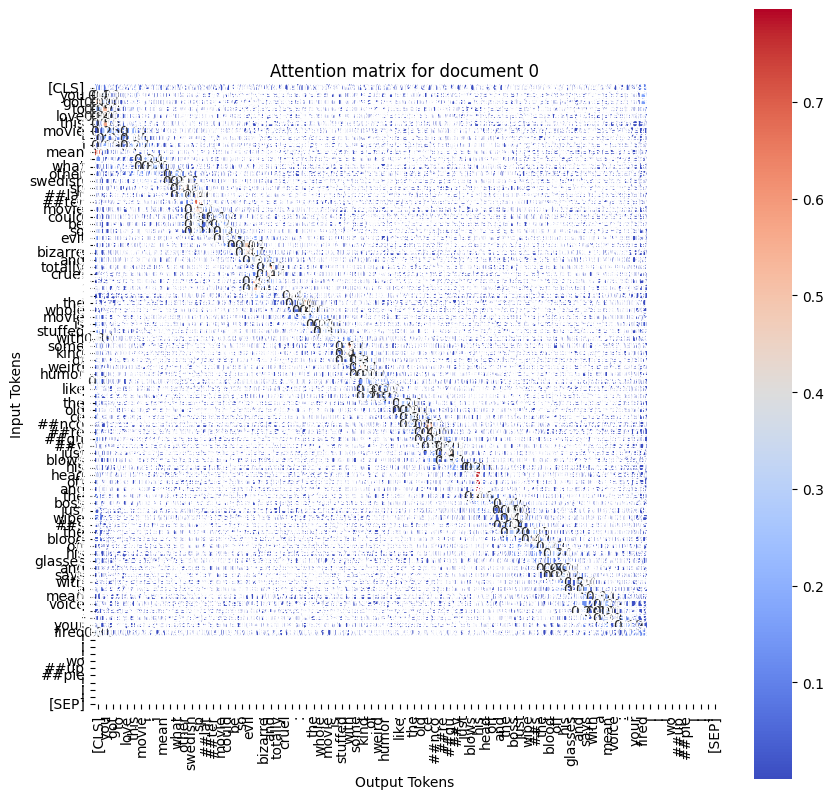

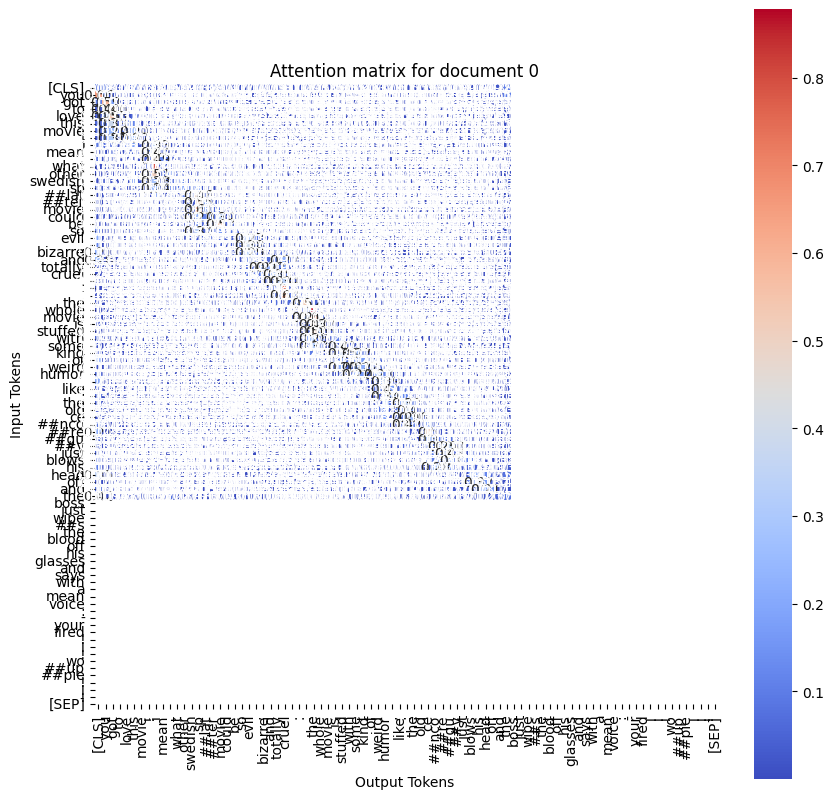

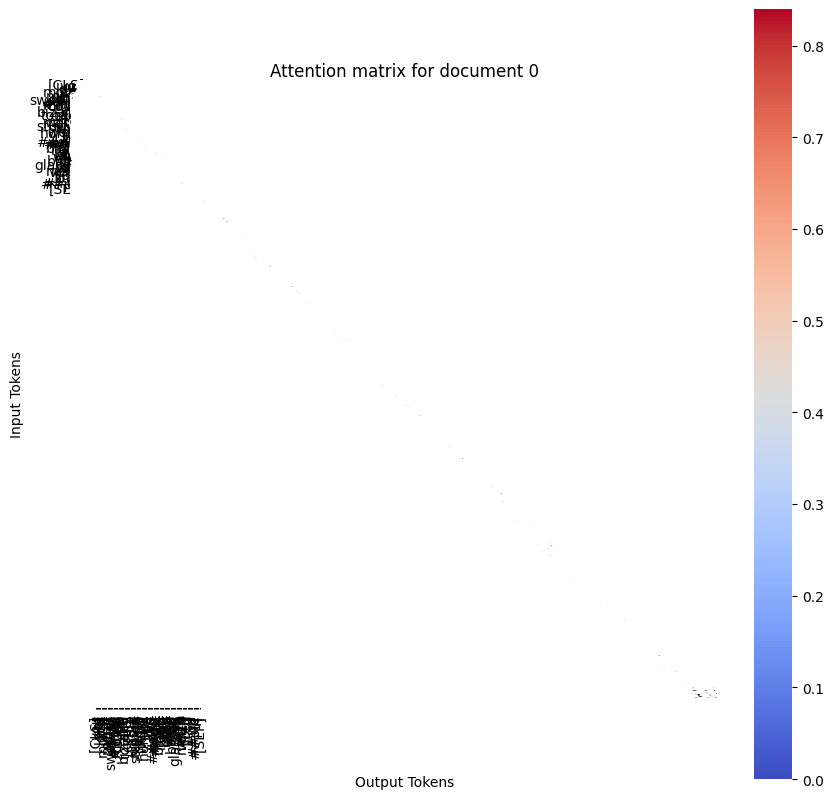

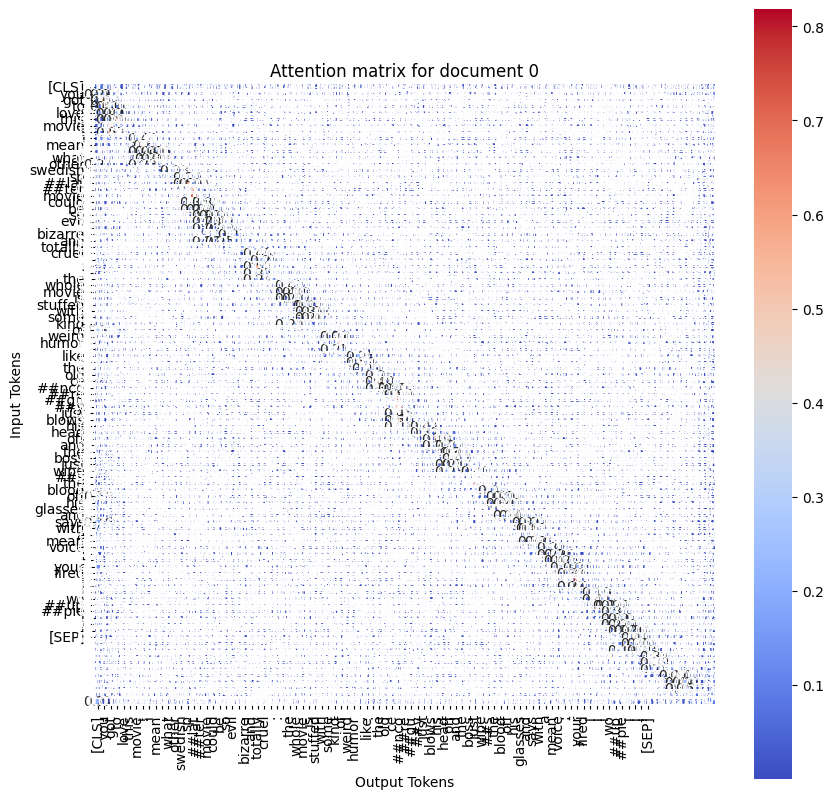

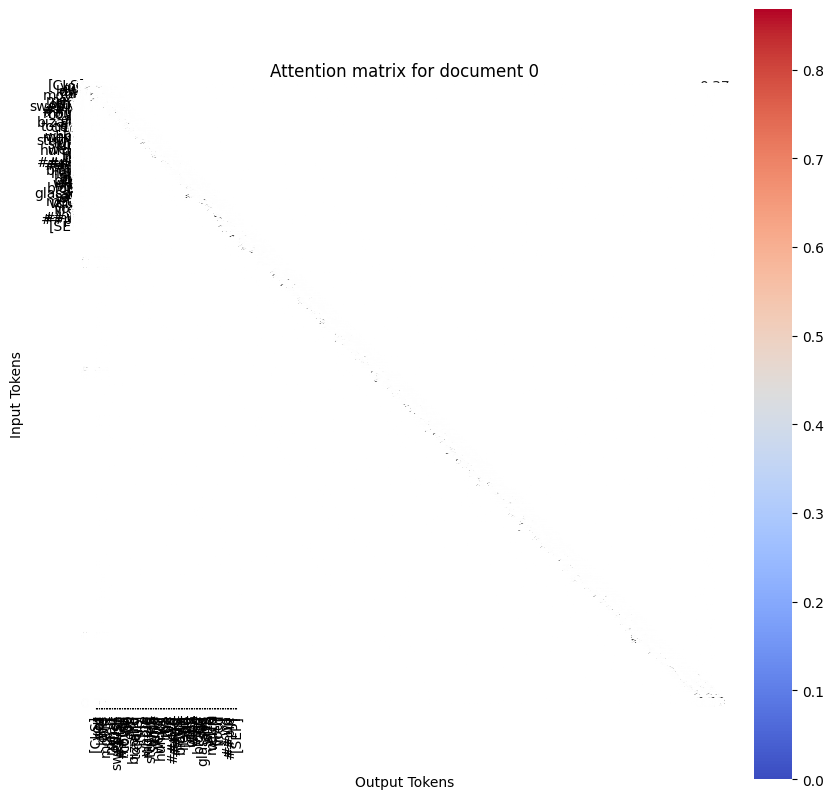

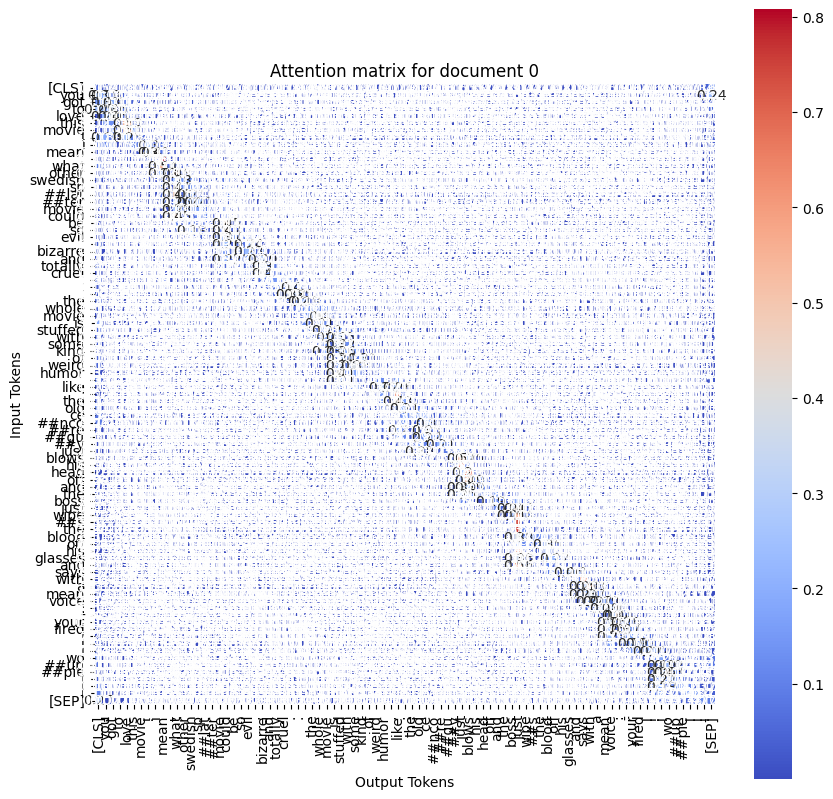

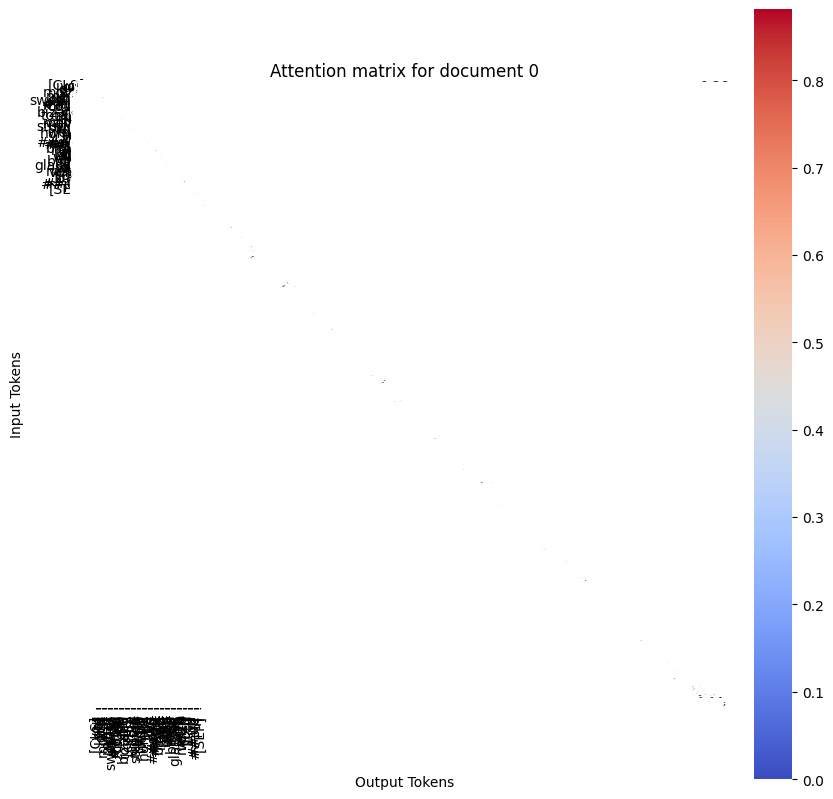

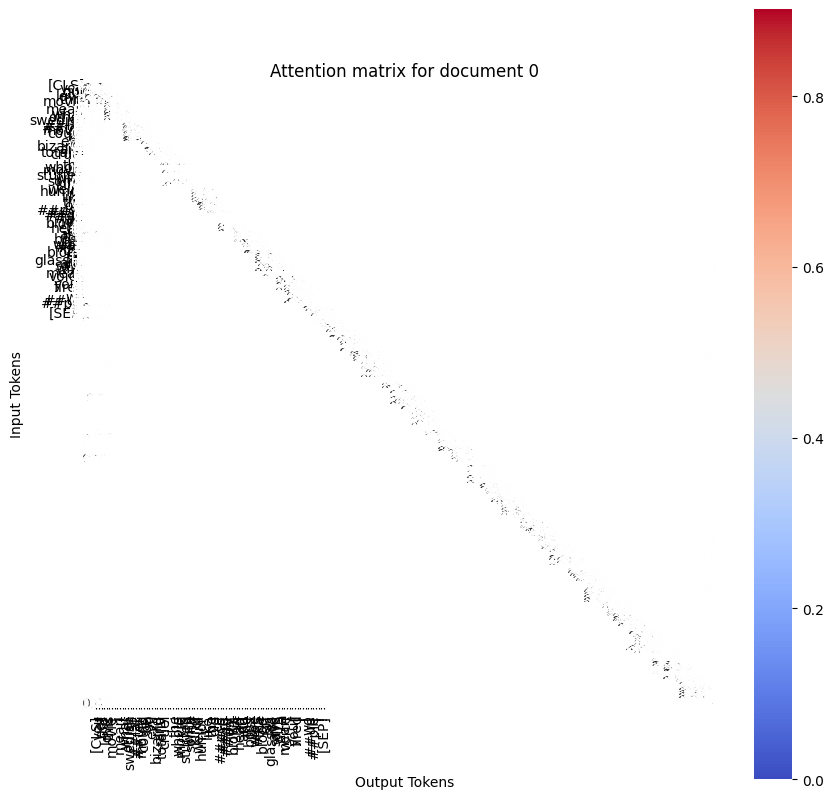

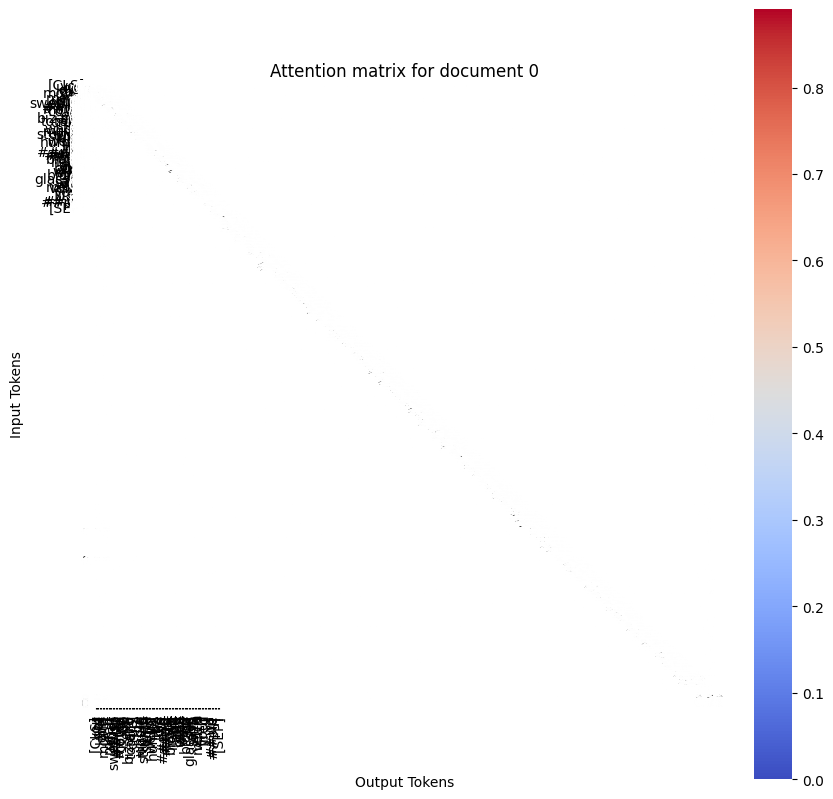

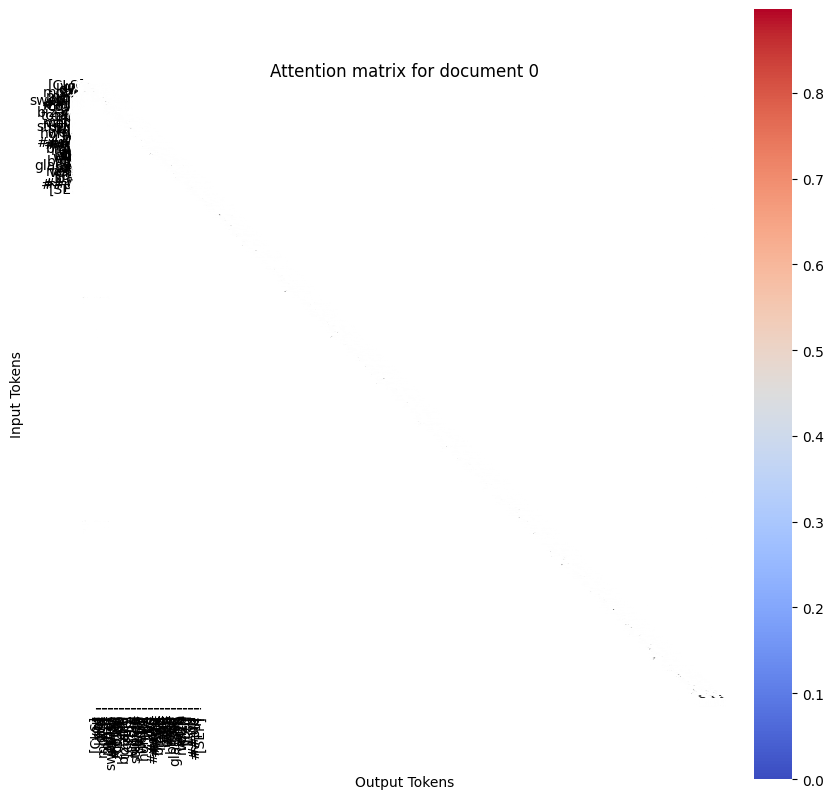

'\nIn this example, the class_token_idx argument is set to -1 to select the [SEP] \ntoken (which often represents the end of a sentence) as the class token, and the \nblock_idx and head_idx arguments are set to 2 and 1, respectively, to select the \nthird transformer block and the second attention head for examining the attention.\n'

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_attention_matrices(model, input_ids_list, tokenizer):
    attention_matrices = []
    model.eval()

    with torch.no_grad():
        for input_ids in input_ids_list:
            input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
            attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)
            output = model(input_ids, attention_mask=attention_mask)
            attention_matrices.append(output.attentions)

    return attention_matrices
    
def visualize_attention(attention, block_idx, head_idx, tokenizer, class_token_idx=-1):
    attention_block = attention[block_idx] # Transformer block
    attention_head = attention_block[:, head_idx, :, :] # Attention head

    for i, (input_ids, attn) in enumerate(zip(X_test_bert, attention_head)):
        class_token = tokenizer.convert_ids_to_tokens(input_ids[class_token_idx])
        input_tokens = tokenizer.convert_ids_to_tokens(input_ids)
        output_tokens = tokenizer.convert_ids_to_tokens(input_ids)

        # Set the class token as the output token
        output_tokens[class_token_idx] = class_token

        attn_matrix = attn.cpu().numpy()

        plt.figure(figsize=(10, 10))
        sns.heatmap(attn_matrix, xticklabels=input_tokens, yticklabels=output_tokens, square=True, cmap="coolwarm", annot=True)
        plt.title(f"Attention matrix for document {i}")
        plt.xlabel('Output Tokens')
        plt.ylabel('Input Tokens')
        plt.show()

# Calculate the correct and incorrect indices
correct_indices = [i for i, (y1, y2) in enumerate(zip(y_test_bert, y_pred_bert)) if y1 == y2]
incorrect_indices = [i for i, (y1, y2) in enumerate(zip(y_test_bert, y_pred_bert)) if y1 != y2]

# Proceed with the rest of the code
correct_X = [X_test_bert[i] for i in correct_indices[:5]]
incorrect_X = [X_test_bert[i] for i in incorrect_indices[:5]]

attention_matrices_correct = get_attention_matrices(model, correct_X, tokenizer)
attention_matrices_incorrect = get_attention_matrices(model, incorrect_X, tokenizer)

# Visualize attention for the first 5 correctly predicted documents
for attn_correct in attention_matrices_correct:
    visualize_attention(attn_correct, block_idx=2, head_idx=1, tokenizer=tokenizer)

# Visualize attention for the first 5 incorrectly predicted documents
for attn_incorrect in attention_matrices_incorrect:
    visualize_attention(attn_incorrect, block_idx=2, head_idx=1, tokenizer=tokenizer)

"""
In this example, the class_token_idx argument is set to -1 to select the [SEP] 
token (which often represents the end of a sentence) as the class token, and the 
block_idx and head_idx arguments are set to 2 and 1, respectively, to select the 
third transformer block and the second attention head for examining the attention.
"""
